In [ ]:
from avcv.all import *

In [ ]:
cc = DiagnoseCoco('/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/mobile_cigarette_train_081522_finetuning.json', 
                '/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/',
                 '../out.json'
                )

creating index...
index created!


In [ ]:
cc.evaluate()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.16s).
Accumulating evaluation results...
DONE (t=0.75s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.830
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.741
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.858
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.859
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.862
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.862
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [ ]:
cc.find_false_samples?

Signature: cc.find_false_samples(img_id, score_thr=0.05, visualize=True)
Docstring: <no docstring>
File:      ~/avcv/avcv/coco.py
Type:      method


In [ ]:
# ret = []
# for img_id in cc.img_ids:
#     ret += cc.find_false_samples(img_id)
ret = multi_thread(lambda x:cc.find_false_samples(x, score_thr=0.5), cc.img_ids, max_workers=8)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8732/8732 [00:46<00:00, 188.04it/s]


In [ ]:
ret_df = []
vis_img_dict = {}
for r,img_id in zip(ret, cc.img_ids):
    ret_df.append([img_id, len(r['tp']), len(r['fn']), len(r['fp'])])
    vis_img_dict[img_id] = r['vis_img']
ret_df = pd.DataFrame(ret_df, columns=['img_id', 'tp', 'fn', 'fp'])

In [ ]:
ret_df['f'] = ret_df.fn+ret_df.fp

In [ ]:
ret_df = ret_df.sort_values('f', ascending=False)

In [ ]:
row = ret_df[ret_df.tp>0].sample(1).iloc[0]

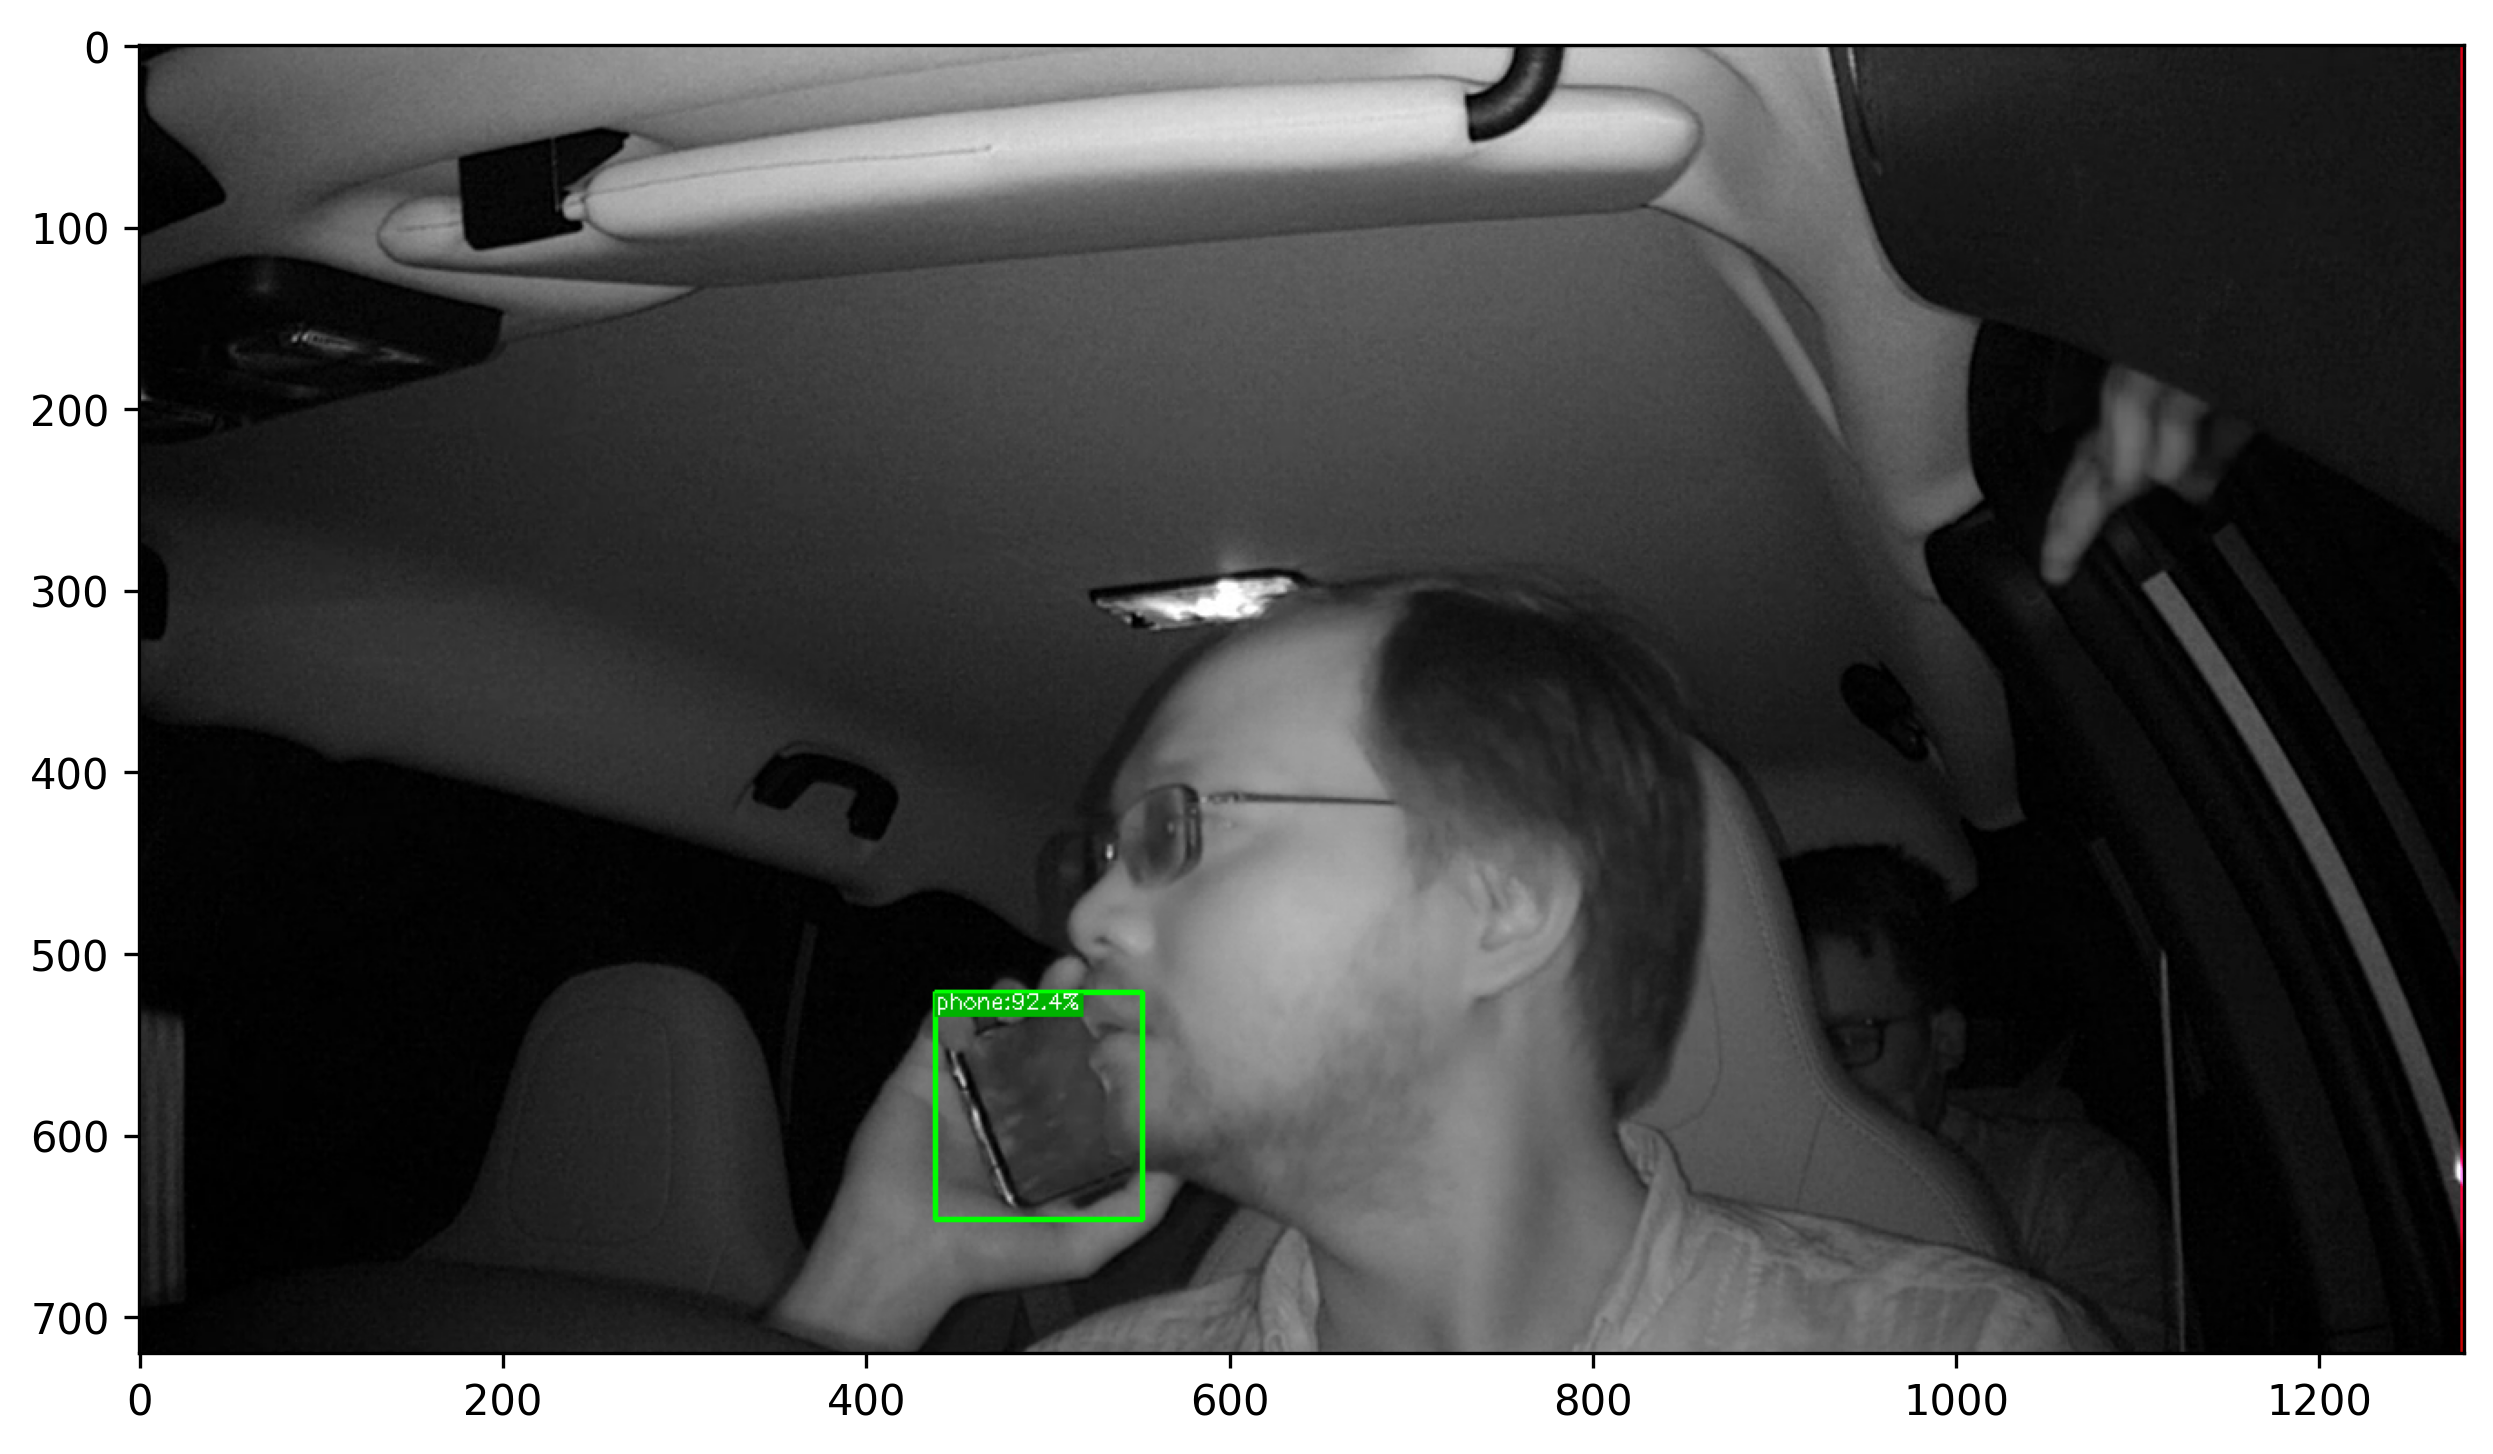

In [ ]:
show(vis_img_dict[row.img_id], dpi=300)

In [ ]:
ds = cc.gt.dataset

In [ ]:
imgid2ann_idx = dict()
for i, ann in enumerate(ds['annotations']):
    if len(cc.gt.imgToAnns[ann['image_id']]) == 1:
        imgid2ann_idx[ann['image_id']] = i
len(imgid2ann_idx)

7025

In [ ]:
for ann in ds['annotations']:
    ann['updated'] = False


for _, row in tqdm(ret_df[ret_df.tp==1].iterrows(), total=len(ret_df)):
    # for pred_ann in cc.pred
    pred_anns = [ann for ann in cc.pred.imgToAnns[row.img_id] if ann['score']>0.86]
    # assert len(pred_anns) == 1
    if len(pred_anns) == 1:
        pred_ann = pred_anns[0]
        # for ann in ds['annotations']:
        if row.img_id in imgid2ann_idx:
            idx = imgid2ann_idx[row.img_id]

            ann = ds['annotations'][idx]
                # if ann['image_id'] == row.img_id:
            ann['updated'] = True
            ann['hand_labeled_bbox'] = ann['bbox']
            ann['bbox'] = pred_ann['bbox']
            ann['area'] = ann['bbox'][-2]*ann['bbox'][-1]
        # break

updated = [ann.get('updated', False) for ann in ds['annotations']]
print(np.mean(updated))


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 6980/8732 [00:00<00:00, 9595.65it/s]

0.8511812137501769


In [ ]:
mmcv.dump(ds, '/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/mobile_cigarette_train_081522_finetuning_updated_v1.json')